In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

# Dataset Path
DATASET_PATH = r"C:\Users\linga\OneDrive\Desktop\mini\tiff"

# Custom Transformation for Mask Binarization
class BinarizeMask(torch.nn.Module):
    def forward(self, x):
        return (x > 0).float()  # Ensure shape (1, H, W)

# Define Image Transformations with Augmentations
class PairedTransform:
    def __init__(self, image_size=128):  # ✅ Changed to 128
        self.image_size = image_size
        self.image_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),  # ✅ Resize to 128x128
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),  # ✅ Resize to 128x128
            transforms.ToTensor(),
            BinarizeMask()  # Use custom class instead of Lambda
        ])

    def __call__(self, img, label):
        # Apply same augmentations to both
        if random.random() > 0.5:
            img = transforms.functional.hflip(img)
            label = transforms.functional.hflip(label)
        if random.random() > 0.5:
            img = transforms.functional.vflip(img)
            label = transforms.functional.vflip(label)

        return self.image_transform(img), self.mask_transform(label)


# Dataset Class
class SatelliteRoadDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))

        # Ensure filenames match (Sanity Check)
        assert len(self.image_filenames) == len(self.label_filenames), "Mismatch in dataset size!"
        assert all(img.split('.')[0] == lbl.split('.')[0]
                   for img, lbl in zip(self.image_filenames, self.label_filenames)), "Image and mask filenames do not match!"

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")  # Convert to grayscale (single channel)

        if self.transform:
            image, label = self.transform(image, label)  # Apply transformation

        return image, label  # Ensure label is (1, 128, 128) for training

# Create DataLoaders
def get_dataloader(batch_size=1, num_workers=0):  # num_workers=0 to avoid multiprocessing issues in Windows
    transform = PairedTransform(image_size=128)  # ✅ Changed to 128

    train_dataset = SatelliteRoadDataset(
        image_dir=os.path.join(DATASET_PATH, "train"),
        label_dir=os.path.join(DATASET_PATH, "train_labels"),
        transform=transform,
    )

    val_dataset = SatelliteRoadDataset(
        image_dir=os.path.join(DATASET_PATH, "val"),
        label_dir=os.path.join(DATASET_PATH, "val_labels"),
        transform=transform,
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_dataset, val_dataset, train_loader, val_loader  # Return all four


# Example Usage
train_dataset, val_dataset, train_loader, val_loader = get_dataloader(batch_size=1)

# Check sample
sample_img, sample_label = next(iter(train_loader))
print("Image Shape:", sample_img.shape)  # ✅ Expected: (1, 3, 128, 128)
print("Label Shape:", sample_label.shape)  # ✅ Expected: (1, 1, 128, 128)


Image Shape: torch.Size([1, 3, 128, 128])
Label Shape: torch.Size([1, 1, 128, 128])


In [ ]:
pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------- ----------------------- 3.4/8.1 MB 20.2 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 12.4 MB/s eta 0:00:01
   -------------------------- ------------- 5.2/8.1 MB 8.8 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 7.4 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 6.6 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 6.6 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 6.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.2 MB 3.7 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.2 MB 3.7 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.2 MB 3.7 MB/s eta 0:00:01
   ---------------------

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of data
train_loader, _ = get_dataloader(batch_size=4)  # Load dataset with batch size 4
sample_img, sample_label = next(iter(train_loader))  # Get a batch

# Convert images back from [-1, 1] to [0, 1] for visualization
def denormalize(tensor):
    return (tensor * 0.5) + 0.5  # Reverse normalization

# Convert tensors to NumPy for plotting
sample_img = denormalize(sample_img).permute(0, 2, 3, 1).cpu().numpy()  # Shape: (batch, H, W, C)
sample_label = denormalize(sample_label).squeeze(1).cpu().numpy()  # Shape: (batch, H, W)

# Plot two images and labels
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):  # Display two samples
    axes[i, 0].imshow(sample_img[i])  # RGB Image
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sample_label[i], cmap="gray")  # Grayscale Mask
    axes[i, 1].set_title("Ground Truth Label")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


ValueError: too many values to unpack (expected 2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Basic Conv Block (Conv -> BatchNorm -> LeakyReLU) ---
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# --- Downsampling (2x2 Max Pool + Conv Block) ---
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        return self.conv(x)

# --- Upsampling (ConvTranspose + Skip Connection) ---
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)  # Expecting concatenated input

    def forward(self, x, skip):
        x = self.up(x)  # Upsample

        # Fix channel mismatch if necessary
        if x.shape[1] != skip.shape[1]:
            diff = skip.shape[1] - x.shape[1]
            pad = torch.zeros(x.shape[0], diff, x.shape[2], x.shape[3], device=x.device)
            x = torch.cat([x, pad], dim=1)

        x = torch.cat([x, skip], dim=1)  # Concatenate along channel axis
        return self.conv(x)

# --- Output Layer (1x1 Conv -> Sigmoid) ---
class OutputBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutputBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return torch.sigmoid(self.conv(x))  # Normalize output to [0,1]

# --- Full U-Net Generator ---
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNetGenerator, self).__init__()

        # Downsampling
        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = DownBlock(64, 128)
        self.enc3 = DownBlock(128, 256)
        self.enc4 = DownBlock(256, 512)

        # Bottleneck
        self.bottleneck = DownBlock(512, 1024)

        # Upsampling
        self.dec4 = UpBlock(1024, 512)
        self.dec3 = UpBlock(512, 256)
        self.dec2 = UpBlock(256, 128)
        self.dec1 = UpBlock(128, 64)

        # Output
        self.output = OutputBlock(64, out_channels)

    def forward(self, x):
        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        s3 = self.enc3(s2)
        s4 = self.enc4(s3)

        # Bottleneck
        b = self.bottleneck(s4)

        # Upsampling with skip connections
        d4 = self.dec4(b, s4)
        d3 = self.dec3(d4, s3)
        d2 = self.dec2(d3, s2)
        d1 = self.dec1(d2, s1)

        return self.output(d1)

# --- Model Initialization ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = UNetGenerator().to(device)

# --- Test Run ---
test_input = torch.randn(1, 3, 256, 256).to(device)  # ✅ Correct Input Shape
test_output = generator(test_input)
print("Output Shape:", test_output.shape)  # ✅ Expected: (1, 1, 256, 256)


Output Shape: torch.Size([1, 1, 256, 256])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Basic Discriminator Block (Conv -> InstanceNorm -> LeakyReLU) ---
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(DiscriminatorBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1),
            nn.InstanceNorm2d(out_channels),  # More stable than BatchNorm for GANs
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# --- Single Scale Discriminator (PatchGAN-Based) ---
class SingleDiscriminator(nn.Module):
    def __init__(self, in_channels=4):
        super(SingleDiscriminator, self).__init__()

        self.block1 = nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)  # No Norm in First Layer
        self.block2 = DiscriminatorBlock(64, 128, stride=2)
        self.block3 = DiscriminatorBlock(128, 256, stride=2)
        self.block4 = DiscriminatorBlock(256, 512, stride=1)  # Reduce size but keep features
        self.output = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Single output channel

    def forward(self, x):
        x = F.leaky_relu(self.block1(x), 0.2, inplace=True)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return torch.sigmoid(self.output(x))  # Output range: [0,1]

# --- Multi-Scale Discriminator (Combines 3 PatchGANs at Different Resolutions) ---
class MultiScaleDiscriminator(nn.Module):
    def __init__(self, in_channels=4):
        super(MultiScaleDiscriminator, self).__init__()
        self.disc1 = SingleDiscriminator(in_channels)  # Full Resolution
        self.disc2 = SingleDiscriminator(in_channels)  # Half Resolution
        self.disc3 = SingleDiscriminator(in_channels)  # Quarter Resolution

    def forward(self, x):
        x2 = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)  # Downscale x by 2
        x3 = F.interpolate(x, scale_factor=0.25, mode='bilinear', align_corners=False)  # Downscale x by 4

        out1 = self.disc1(x)  # Full Res
        out2 = self.disc2(x2)  # Half Res
        out3 = self.disc3(x3)  # Quarter Res

        return [out1, out2, out3]  # Multi-Scale Outputs

# --- Initialize Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator = MultiScaleDiscriminator().to(device)

# --- Test Run ---
test_input = torch.randn(1, 4, 128, 128).to(device)  # ✅ Correct Input Shape
test_output = discriminator(test_input)

# Output shapes (PatchGAN outputs different sizes)
print("Discriminator Output Shapes:")
for i, out in enumerate(test_output):
    print(f"Scale {i+1} Output Shape:", out.shape)  # ✅ Expected: Smaller patch outputs


Discriminator Output Shapes:
Scale 1 Output Shape: torch.Size([1, 1, 14, 14])
Scale 2 Output Shape: torch.Size([1, 1, 6, 6])
Scale 3 Output Shape: torch.Size([1, 1, 2, 2])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# SSIM Loss Function
class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()

    def forward(self, img1, img2):
        return 1 - torchvision.transforms.functional.ssim(img1, img2, data_range=1.0)

# Generator Loss
class GeneratorLoss(nn.Module):
    def __init__(self, lambda_L1=100):
        super(GeneratorLoss, self).__init__()
        self.adv_loss = nn.BCEWithLogitsLoss()  # Adversarial Loss
        self.l1_loss = nn.L1Loss()  # L1 Loss for Pixel Difference
        self.ssim_loss = SSIMLoss()  # Structural Similarity Loss
        self.lambda_L1 = lambda_L1
        self.lambda_SSIM = 1.0  # Weight for SSIM loss

    def forward(self, fake_images, real_images, disc_fake_outputs):
        adv_loss = self.adv_loss(disc_fake_outputs, torch.ones_like(disc_fake_outputs))  # Fool the discriminator
        l1_loss = self.l1_loss(fake_images, real_images)
        ssim_loss = self.ssim_loss(fake_images, real_images)

        total_loss = adv_loss + self.lambda_L1 * l1_loss + self.lambda_SSIM * ssim_loss
        return total_loss, {"Adv Loss": adv_loss.item(), "L1 Loss": l1_loss.item(), "SSIM Loss": ssim_loss.item()}

# Discriminator Loss
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.adv_loss = nn.BCEWithLogitsLoss()  # Binary Cross Entropy for Real vs Fake

    def forward(self, disc_real_outputs, disc_fake_outputs):
        real_loss = self.adv_loss(disc_real_outputs, torch.ones_like(disc_real_outputs))  # Real = 1
        fake_loss = self.adv_loss(disc_fake_outputs, torch.zeros_like(disc_fake_outputs))  # Fake = 0
        total_loss = (real_loss + fake_loss) / 2
        return total_loss, {"D Real Loss": real_loss.item(), "D Fake Loss": fake_loss.item()}


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

generator = UNetGenerator().to(device)
discriminator = MultiScaleDiscriminator().to(device)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import os
from torch.amp import GradScaler, autocast  # ✅ Fixed Import
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm  # ✅ Added Progress Bar

# --- Device Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Define Model (Generator & Discriminator) ---
generator = UNetGenerator().to(device)
discriminator = MultiScaleDiscriminator().to(device)

# --- Loss Functions ---
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

# --- Optimizers ---
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# --- AMP Mixed Precision Scaler ---
scaler = GradScaler("cuda")

# --- Checkpoint & Output Directory ---
checkpoint_dir = "./checkpoints"
output_dir = "./output_images"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)  # ✅ Ensure output directory exists

# --- Training Loop ---
num_epochs = 50
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    epoch_loss_G, epoch_loss_D = 0, 0  # ✅ Track losses

    # ✅ Progress Bar for Training
    train_progress = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for real_images, real_masks in train_progress:
        real_images, real_masks = real_images.to(device), real_masks.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        with autocast("cuda"):  # ✅ Fixed AMP usage
            fake_masks = generator(real_images)

            disc_real_inputs = torch.cat((real_images, real_masks), dim=1)
            disc_fake_inputs = torch.cat((real_images, fake_masks.detach()), dim=1)

            disc_real_outputs = discriminator(disc_real_inputs)
            disc_fake_outputs = discriminator(disc_fake_inputs)

            loss_D_real = sum(bce_loss(out, torch.ones_like(out)) for out in disc_real_outputs) / len(disc_real_outputs)
            loss_D_fake = sum(bce_loss(out, torch.zeros_like(out)) for out in disc_fake_outputs) / len(disc_fake_outputs)
            loss_D = (loss_D_real + loss_D_fake) * 0.5

        scaler.scale(loss_D).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # --- Train Generator ---
        optimizer_G.zero_grad()
        with autocast("cuda"):  # ✅ Fixed AMP usage
            fake_masks = generator(real_images)

            disc_fake_inputs = torch.cat((real_images, fake_masks), dim=1)
            disc_fake_outputs = discriminator(disc_fake_inputs)

            loss_G_GAN = sum(bce_loss(out, torch.ones_like(out)) for out in disc_fake_outputs) / len(disc_fake_outputs)
            loss_G_L1 = l1_loss(fake_masks, real_masks) * 100
            loss_G = loss_G_GAN + loss_G_L1

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # ✅ Track Epoch Losses
        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    # ✅ Compute Average Training Losses
    avg_train_loss_G = epoch_loss_G / len(train_loader)
    avg_train_loss_D = epoch_loss_D / len(train_loader)

    # --- Validation ---
    generator.eval()
    val_loss_G = 0  # ✅ Track Validation Loss
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            fake_masks = generator(val_images)

            disc_fake_inputs = torch.cat((val_images, fake_masks), dim=1)
            disc_fake_outputs = discriminator(disc_fake_inputs)

            loss_G_GAN_val = sum(bce_loss(out, torch.ones_like(out)) for out in disc_fake_outputs) / len(disc_fake_outputs)
            loss_G_L1_val = l1_loss(fake_masks, val_masks) * 100
            loss_G_val = loss_G_GAN_val + loss_G_L1_val  # ✅ Total Validation Loss

            val_loss_G += loss_G_val.item()

            # ✅ Save Sample Validation Image (Ensure Directory Exists)
            save_path = os.path.join(output_dir, f"epoch_{epoch}_sample.png")
            save_image(fake_masks, save_path)

    # ✅ Compute Average Validation Loss
    avg_val_loss_G = val_loss_G / len(val_loader)

    # ✅ Print Epoch Summary (Single Log Per Epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] → "
          f"Train Loss G: {avg_train_loss_G:.4f}, Train Loss D: {avg_train_loss_D:.4f}, "
          f"Val Loss G: {avg_val_loss_G:.4f}")

    # --- Save Model Checkpoint ---
    torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f"generator_epoch_{epoch+1}.pth"))
    torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch+1}.pth"))

print("Training Completed! 🎉")


Epoch [1/50] → Train Loss G: 23.7886, Train Loss D: 0.5971, Val Loss G: 21.4768


Epoch [2/50] → Train Loss G: 16.0495, Train Loss D: 0.6175, Val Loss G: 19.7495


Epoch [3/50] → Train Loss G: 14.0801, Train Loss D: 0.6320, Val Loss G: 18.9867


Epoch [4/50] → Train Loss G: 13.0092, Train Loss D: 0.6382, Val Loss G: 21.1647


Epoch [5/50] → Train Loss G: 12.2951, Train Loss D: 0.6357, Val Loss G: 20.8928


Epoch [6/50] → Train Loss G: 11.7821, Train Loss D: 0.6322, Val Loss G: 16.4516


Epoch [7/50] → Train Loss G: 11.3899, Train Loss D: 0.6266, Val Loss G: 16.8972


Epoch [8/50] → Train Loss G: 11.0832, Train Loss D: 0.6233, Val Loss G: 15.5537


Epoch [9/50] → Train Loss G: 10.8990, Train Loss D: 0.6235, Val Loss G: 15.8126


Epoch [10/50] → Train Loss G: 10.6131, Train Loss D: 0.6211, Val Loss G: 14.6106


Epoch [11/50] → Train Loss G: 10.4796, Train Loss D: 0.6213, Val Loss G: 18.4400


Epoch [12/50] → Train Loss G: 10.3111, Train Loss D: 0.6190, Val Loss G: 14.5934


Epoch [13/50] → Train Loss G: 10.1601, Train Loss D: 0.6180, Val Loss G: 13.4469


Epoch [14/50] → Train Loss G: 10.0842, Train Loss D: 0.6191, Val Loss G: 13.7507


Epoch [15/50] → Train Loss G: 9.9414, Train Loss D: 0.6158, Val Loss G: 14.2137


Epoch [16/50] → Train Loss G: 9.8953, Train Loss D: 0.6147, Val Loss G: 13.5786


Epoch [17/50] → Train Loss G: 9.8727, Train Loss D: 0.6144, Val Loss G: 13.8913


Epoch [18/50] → Train Loss G: 9.7234, Train Loss D: 0.6089, Val Loss G: 15.0550


Epoch [19/50] → Train Loss G: 9.6752, Train Loss D: 0.6058, Val Loss G: 13.3974


Epoch [20/50] → Train Loss G: 9.6091, Train Loss D: 0.6021, Val Loss G: 14.3298


Epoch [21/50] → Train Loss G: 9.5301, Train Loss D: 0.6036, Val Loss G: 13.7577


Epoch [22/50] → Train Loss G: 9.4948, Train Loss D: 0.6059, Val Loss G: 12.7850


Epoch [23/50] → Train Loss G: 9.4202, Train Loss D: 0.5991, Val Loss G: 14.9501


Epoch [24/50] → Train Loss G: 9.3662, Train Loss D: 0.6011, Val Loss G: 12.2608


Epoch [25/50] → Train Loss G: 9.3472, Train Loss D: 0.5986, Val Loss G: 12.4577


Epoch [26/50] → Train Loss G: 9.2903, Train Loss D: 0.5975, Val Loss G: 13.6876


Epoch [27/50] → Train Loss G: 9.2608, Train Loss D: 0.5966, Val Loss G: 11.7478


Epoch [28/50] → Train Loss G: 9.1765, Train Loss D: 0.5943, Val Loss G: 13.0387


Epoch [29/50] → Train Loss G: 9.1639, Train Loss D: 0.5937, Val Loss G: 12.3631


Epoch [30/50] → Train Loss G: 9.1167, Train Loss D: 0.5899, Val Loss G: 12.2733


Epoch [31/50] → Train Loss G: 9.0604, Train Loss D: 0.5922, Val Loss G: 12.8023


Epoch [32/50] → Train Loss G: 9.0430, Train Loss D: 0.5953, Val Loss G: 11.8669


Epoch [33/50] → Train Loss G: 9.0069, Train Loss D: 0.5906, Val Loss G: 12.6243


Epoch [34/50] → Train Loss G: 8.9827, Train Loss D: 0.5939, Val Loss G: 19.0825


Epoch [35/50] → Train Loss G: 8.9269, Train Loss D: 0.5897, Val Loss G: 12.0417


Epoch [36/50] → Train Loss G: 8.9329, Train Loss D: 0.5882, Val Loss G: 11.5015


Epoch [37/50] → Train Loss G: 8.8949, Train Loss D: 0.5871, Val Loss G: 14.8559


Epoch [38/50] → Train Loss G: 8.8366, Train Loss D: 0.5884, Val Loss G: 11.9592


Epoch [39/50] → Train Loss G: 8.8059, Train Loss D: 0.5887, Val Loss G: 12.5453


Epoch [40/50] → Train Loss G: 8.7580, Train Loss D: 0.5910, Val Loss G: 13.9424


Epoch [41/50] → Train Loss G: 8.7528, Train Loss D: 0.5900, Val Loss G: 12.5603


Epoch [42/50] → Train Loss G: 8.7134, Train Loss D: 0.5934, Val Loss G: 13.9400


Epoch [43/50] → Train Loss G: 8.7302, Train Loss D: 0.5895, Val Loss G: 12.1965


Epoch [44/50] → Train Loss G: 8.6677, Train Loss D: 0.5879, Val Loss G: 12.5254


Epoch [45/50] → Train Loss G: 8.6651, Train Loss D: 0.5887, Val Loss G: 13.1377


Epoch [46/50] → Train Loss G: 8.5937, Train Loss D: 0.5871, Val Loss G: 12.5238


Epoch [47/50] → Train Loss G: 8.5901, Train Loss D: 0.5848, Val Loss G: 12.6463


Epoch [48/50] → Train Loss G: 8.5892, Train Loss D: 0.5882, Val Loss G: 11.8125


Epoch [49/50] → Train Loss G: 8.5362, Train Loss D: 0.5862, Val Loss G: 12.6134


Epoch [50/50] → Train Loss G: 8.5298, Train Loss D: 0.5850, Val Loss G: 11.7684
Training Completed! 🎉


In [ ]:
# Define save path
MODEL_SAVE_PATH = "generator_model.pth"

# Save the trained generator model
torch.save(generator.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")


Model saved to generator_model.pth


In [ ]:
# Define save path for the discriminator
DISCRIMINATOR_SAVE_PATH = "discriminator_model.pth"

# Save the trained discriminator model
torch.save(discriminator.state_dict(), DISCRIMINATOR_SAVE_PATH)

print(f"Discriminator saved to {DISCRIMINATOR_SAVE_PATH}")


Discriminator saved to discriminator_model.pth


In [ ]:
# Create Test Dataset with Same Transformations
class TestDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))

        # Ensure filenames match
        assert len(self.image_filenames) == len(self.label_filenames), "Mismatch in test dataset size!"
        assert all(img.split('.')[0] == lbl.split('.')[0]
                   for img, lbl in zip(self.image_filenames, self.label_filenames)), "Image and mask filenames do not match!"

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")  # Convert to grayscale (single channel)

        if self.transform:
            image, label = self.transform(image, label)  # Apply same preprocessing

        return image, label

# Define a function to get the Test DataLoader
def get_test_dataloader(batch_size=1):
    transform = PairedTransform(image_size=128)  # ✅ Same as training

    test_dataset = TestDataset(
        image_dir=os.path.join(DATASET_PATH, "test"),
        label_dir=os.path.join(DATASET_PATH, "test_labels"),
        transform=transform,
    )

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    return test_dataset, test_loader


In [ ]:
test_dataset, test_loader = get_test_dataloader(batch_size=1)

# Check a sample
test_img, test_label = next(iter(test_loader))
print("Test Image Shape:", test_img.shape)  # ✅ Expected: (1, 3, 128, 128)
print("Test Label Shape:", test_label.shape)  # ✅ Expected: (1, 1, 128, 128)


Test Image Shape: torch.Size([1, 3, 128, 128])
Test Label Shape: torch.Size([1, 1, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.5137255].


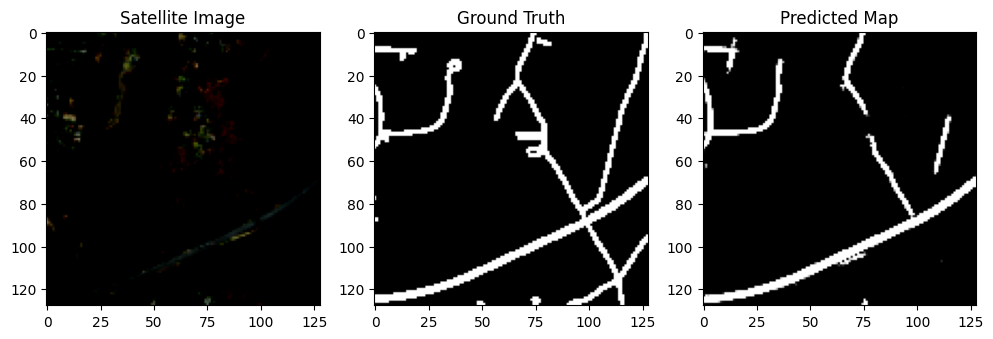

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to show results
def show_prediction(image, true_mask, model):
    image = image.to(device).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        pred_mask = model(image)
        pred_mask = torch.sigmoid(pred_mask).cpu().numpy()[0, 0]  # Convert to numpy

    image = image.cpu().squeeze().permute(1, 2, 0).numpy()  # Convert tensor to numpy
   # image = np.clip(image, 0, 1)  # Ensure values are in range [0,1]

    true_mask = true_mask.cpu().squeeze().numpy()  # Convert tensor to numpy
    pred_mask = np.clip(pred_mask, 0, 1)  # Clip prediction

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)  # No more errors!
    plt.title("Satellite Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="gray")
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Map")

    plt.show()

# Test on one image
test_img, test_label = next(iter(test_loader))  # Get a sample from the test set
show_prediction(test_img[0], test_label[0], generator)


In [ ]:

import torch

# Function to calculate pixel accuracy
def pixel_accuracy(pred_mask, true_mask):
    pred_binary = (pred_mask > 0.5).float()  # Convert to binary mask (threshold at 0.5)
    correct = (pred_binary == true_mask).sum().item()
    total = true_mask.numel()
    return correct / total  # Pixel accuracy

# Function to calculate IoU (Jaccard Index)
def iou_score(pred_mask, true_mask):
    pred_binary = (pred_mask > 0.5).float()
    intersection = (pred_binary * true_mask).sum().item()
    union = (pred_binary + true_mask).clamp(0, 1).sum().item()
    return intersection / union if union != 0 else 1  # Avoid division by zero

# Function to calculate Dice Score
def dice_score(pred_mask, true_mask):
    pred_binary = (pred_mask > 0.5).float()
    intersection = (pred_binary * true_mask).sum().item()
    return (2. * intersection) / (pred_binary.sum().item() + true_mask.sum().item())

# Function to evaluate the model on one image
def evaluate_model(image, true_mask, model):
    image = image.to(device).unsqueeze(0)  # Add batch dimension
    true_mask = true_mask.to(device)

    with torch.no_grad():
        pred_mask = model(image)
        pred_mask = torch.sigmoid(pred_mask).cpu().squeeze()  # Convert to numpy

    # Convert ground truth to binary mask
    true_mask = (true_mask.cpu().squeeze() / 255.0).float()  # Normalize to 0-1

    # Compute metrics
    acc = pixel_accuracy(pred_mask, true_mask)
    iou = iou_score(pred_mask, true_mask)
    dice = dice_score(pred_mask, true_mask)

    print(f"Pixel Accuracy: {acc:.4f}")


    return acc

# Test on one image
test_img, test_label = next(iter(test_loader))  # Get a sample from the test set
evaluate_model(test_img[0], test_label[0], generator)


Pixel Accuracy: 0.8163


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.amp import autocast, GradScaler


In [ ]:
import torch.nn as nn

# Loss Functions
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()


In [ ]:
from torch.amp import GradScaler

scaler = GradScaler("cuda")


In [ ]:
import os

checkpoint_dir = "./checkpoints"
output_dir = "./output_images"

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)


In [ ]:
from torchvision.utils import save_image


In [ ]:
import torch
import torch.optim as optim  # ✅ Make sure this is here

# Load models with future-safe flag
generator.load_state_dict(torch.load("./generator_model.pth", weights_only=True))
discriminator.load_state_dict(torch.load("./discriminator_model.pth", weights_only=True))

# Recreate optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))


# Continue Training for 30 more epochs (from 51 to 80)
num_epochs_extra = 30
start_epoch = 50  # Since you already finished epoch 50

for epoch in range(start_epoch, start_epoch + num_epochs_extra):
    generator.train()
    discriminator.train()

    epoch_loss_G, epoch_loss_D = 0, 0
    train_progress = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{start_epoch + num_epochs_extra}]", leave=False)

    for real_images, real_masks in train_progress:
        real_images, real_masks = real_images.to(device), real_masks.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        with autocast("cuda"):
            fake_masks = generator(real_images)
            disc_real_inputs = torch.cat((real_images, real_masks), dim=1)
            disc_fake_inputs = torch.cat((real_images, fake_masks.detach()), dim=1)

            disc_real_outputs = discriminator(disc_real_inputs)
            disc_fake_outputs = discriminator(disc_fake_inputs)

            loss_D_real = sum(bce_loss(out, torch.ones_like(out)) for out in disc_real_outputs) / len(disc_real_outputs)
            loss_D_fake = sum(bce_loss(out, torch.zeros_like(out)) for out in disc_fake_outputs) / len(disc_fake_outputs)
            loss_D = (loss_D_real + loss_D_fake) * 0.5

        scaler.scale(loss_D).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # --- Train Generator ---
        optimizer_G.zero_grad()
        with autocast("cuda"):
            fake_masks = generator(real_images)
            disc_fake_inputs = torch.cat((real_images, fake_masks), dim=1)
            disc_fake_outputs = discriminator(disc_fake_inputs)

            loss_G_GAN = sum(bce_loss(out, torch.ones_like(out)) for out in disc_fake_outputs) / len(disc_fake_outputs)
            loss_G_L1 = l1_loss(fake_masks, real_masks) * 100
            loss_G = loss_G_GAN + loss_G_L1

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    avg_train_loss_G = epoch_loss_G / len(train_loader)
    avg_train_loss_D = epoch_loss_D / len(train_loader)

    # --- Validation ---
    generator.eval()
    val_loss_G = 0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            fake_masks = generator(val_images)

            disc_fake_inputs = torch.cat((val_images, fake_masks), dim=1)
            disc_fake_outputs = discriminator(disc_fake_inputs)

            loss_G_GAN_val = sum(bce_loss(out, torch.ones_like(out)) for out in disc_fake_outputs) / len(disc_fake_outputs)
            loss_G_L1_val = l1_loss(fake_masks, val_masks) * 100
            loss_G_val = loss_G_GAN_val + loss_G_L1_val

            val_loss_G += loss_G_val.item()

            # ✅ Save validation sample
            save_path = os.path.join(output_dir, f"epoch_{epoch}_sample.png")
            save_image(fake_masks, save_path)

    avg_val_loss_G = val_loss_G / len(val_loader)

    print(f"Epoch [{epoch+1}/{start_epoch + num_epochs_extra}] → "
          f"Train Loss G: {avg_train_loss_G:.4f}, Train Loss D: {avg_train_loss_D:.4f}, "
          f"Val Loss G: {avg_val_loss_G:.4f}")

    # Save updated models
    torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f"generator_epoch_{epoch+1}.pth"))
    torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch+1}.pth"))

# Final Save (optional overwrite or rename)
torch.save(generator.state_dict(), "./generator_model.pth")
torch.save(discriminator.state_dict(), "./discriminator_model.pth")

print("✅ Continued training for 30 more epochs completed!")


Epoch [51/80] → Train Loss G: 8.4912, Train Loss D: 0.5877, Val Loss G: 11.9051


Epoch [52/80] → Train Loss G: 8.4852, Train Loss D: 0.5843, Val Loss G: 11.8807


Epoch [53/80] → Train Loss G: 8.4186, Train Loss D: 0.5849, Val Loss G: 11.7740


Epoch [54/80] → Train Loss G: 8.4109, Train Loss D: 0.5847, Val Loss G: 12.4249


Epoch [55/80] → Train Loss G: 8.3976, Train Loss D: 0.5847, Val Loss G: 13.8105


Epoch [56/80] → Train Loss G: 8.3838, Train Loss D: 0.5863, Val Loss G: 12.5921


Epoch [57/80] → Train Loss G: 8.3533, Train Loss D: 0.5824, Val Loss G: 13.7195


Epoch [58/80] → Train Loss G: 8.3510, Train Loss D: 0.5833, Val Loss G: 12.4517


Epoch [59/80] → Train Loss G: 8.2890, Train Loss D: 0.5827, Val Loss G: 13.1739


Epoch [60/80] → Train Loss G: 8.2990, Train Loss D: 0.5844, Val Loss G: 12.1436


Epoch [61/80] → Train Loss G: 8.2581, Train Loss D: 0.5827, Val Loss G: 11.5447


Epoch [62/80] → Train Loss G: 8.2530, Train Loss D: 0.5835, Val Loss G: 11.3934


Epoch [63/80] → Train Loss G: 8.2035, Train Loss D: 0.5816, Val Loss G: 12.4075


Epoch [64/80] → Train Loss G: 8.2295, Train Loss D: 0.5822, Val Loss G: 11.8174


Epoch [65/80] → Train Loss G: 8.1912, Train Loss D: 0.5840, Val Loss G: 13.1421


Epoch [66/80] → Train Loss G: 8.1577, Train Loss D: 0.5801, Val Loss G: 12.6432


Epoch [67/80] → Train Loss G: 8.1464, Train Loss D: 0.5829, Val Loss G: 13.0538


Epoch [68/80] → Train Loss G: 8.1359, Train Loss D: 0.5818, Val Loss G: 12.4653


Epoch [69/80] → Train Loss G: 8.0955, Train Loss D: 0.5826, Val Loss G: 11.7406


Epoch [70/80] → Train Loss G: 8.0957, Train Loss D: 0.5819, Val Loss G: 11.9977


Epoch [71/80] → Train Loss G: 8.0665, Train Loss D: 0.5796, Val Loss G: 12.3055


Epoch [72/80] → Train Loss G: 8.0236, Train Loss D: 0.5821, Val Loss G: 12.0415


Epoch [73/80] → Train Loss G: 8.0157, Train Loss D: 0.5826, Val Loss G: 11.3223


Epoch [74/80] → Train Loss G: 8.0027, Train Loss D: 0.5798, Val Loss G: 11.9921


Epoch [75/80] → Train Loss G: 7.9853, Train Loss D: 0.5788, Val Loss G: 12.2727


Epoch [76/80] → Train Loss G: 7.9879, Train Loss D: 0.5797, Val Loss G: 12.0192


Epoch [77/80] → Train Loss G: 7.9551, Train Loss D: 0.5798, Val Loss G: 12.0380


Epoch [78/80] → Train Loss G: 7.9319, Train Loss D: 0.5786, Val Loss G: 11.6164


Epoch [79/80] → Train Loss G: 7.9176, Train Loss D: 0.5815, Val Loss G: 13.1271


Epoch [80/80] → Train Loss G: 7.8873, Train Loss D: 0.5809, Val Loss G: 12.0641
✅ Continued training for 30 more epochs completed!


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torchvision.utils import save_image
from tqdm import tqdm

# ✅ Assume these are already defined:
# generator, discriminator, device, train_loader, val_loader
# If not, initialize them before running the loop.

# ✅ Define losses if not already done
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

# ✅ Paths
output_dir = "./generated_samples"
checkpoint_dir = "./checkpoints"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# ✅ Load pretrained weights
generator.load_state_dict(torch.load("./generator_model.pth", map_location=device))
discriminator.load_state_dict(torch.load("./discriminator_model.pth", map_location=device))

# ✅ Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# ✅ AMP scaler
scaler = GradScaler()

# 🔁 Continue training from epoch 80 to 100
start_epoch = 80
num_epochs_extra = 20  # for 80 to 100

for epoch in range(start_epoch, start_epoch + num_epochs_extra):
    generator.train()
    discriminator.train()
    epoch_loss_G, epoch_loss_D = 0, 0

    train_progress = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{start_epoch + num_epochs_extra}]", leave=False)
    for real_images, real_masks in train_progress:
        real_images, real_masks = real_images.to(device), real_masks.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        with autocast("cuda"):
            fake_masks = generator(real_images)
            disc_real_inputs = torch.cat((real_images, real_masks), dim=1)
            disc_fake_inputs = torch.cat((real_images, fake_masks.detach()), dim=1)

            disc_real_outputs = discriminator(disc_real_inputs)
            disc_fake_outputs = discriminator(disc_fake_inputs)

            loss_D_real = sum(bce_loss(out, torch.ones_like(out)) for out in disc_real_outputs) / len(disc_real_outputs)
            loss_D_fake = sum(bce_loss(out, torch.zeros_like(out)) for out in disc_fake_outputs) / len(disc_fake_outputs)
            loss_D = (loss_D_real + loss_D_fake) * 0.5

        scaler.scale(loss_D).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # --- Train Generator ---
        optimizer_G.zero_grad()
        with autocast("cuda"):
            fake_masks = generator(real_images)
            disc_fake_inputs = torch.cat((real_images, fake_masks), dim=1)
            disc_fake_outputs = discriminator(disc_fake_inputs)

            loss_G_GAN = sum(bce_loss(out, torch.ones_like(out)) for out in disc_fake_outputs) / len(disc_fake_outputs)
            loss_G_L1 = l1_loss(fake_masks, real_masks) * 100
            loss_G = loss_G_GAN + loss_G_L1

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    avg_train_loss_G = epoch_loss_G / len(train_loader)
    avg_train_loss_D = epoch_loss_D / len(train_loader)

    # --- Validation ---
    generator.eval()
    val_loss_G = 0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            fake_masks = generator(val_images)

            disc_fake_inputs = torch.cat((val_images, fake_masks), dim=1)
            disc_fake_outputs = discriminator(disc_fake_inputs)

            loss_G_GAN_val = sum(bce_loss(out, torch.ones_like(out)) for out in disc_fake_outputs) / len(disc_fake_outputs)
            loss_G_L1_val = l1_loss(fake_masks, val_masks) * 100
            loss_G_val = loss_G_GAN_val + loss_G_L1_val

            val_loss_G += loss_G_val.item()

            # ✅ Save validation sample
            save_path = os.path.join(output_dir, f"epoch_{epoch}_sample.png")
            save_image(fake_masks, save_path)

    avg_val_loss_G = val_loss_G / len(val_loader)

    print(f"Epoch [{epoch+1}/{start_epoch + num_epochs_extra}] → "
          f"Train Loss G: {avg_train_loss_G:.4f}, Train Loss D: {avg_train_loss_D:.4f}, "
          f"Val Loss G: {avg_val_loss_G:.4f}")

    # ✅ Save model checkpoints
    torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f"generator_epoch_{epoch+1}.pth"))
    torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch+1}.pth"))

# ✅ Final Save (overwrite or backup)
torch.save(generator.state_dict(), "./generator_model1.pth")
torch.save(discriminator.state_dict(), "./discriminator_model1.pth")

print("✅ Continued training from epoch 80 to 100 completed!")


In [ ]:
# Create Test Dataset with Same Transformations
class TestDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))

        # Ensure filenames match
        assert len(self.image_filenames) == len(self.label_filenames), "Mismatch in test dataset size!"
        assert all(img.split('.')[0] == lbl.split('.')[0]
                   for img, lbl in zip(self.image_filenames, self.label_filenames)), "Image and mask filenames do not match!"

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")  # Convert to grayscale (single channel)

        if self.transform:
            image, label = self.transform(image, label)  # Apply same preprocessing

        return image, label

# Define a function to get the Test DataLoader
def get_test_dataloader(batch_size=1):
    transform = PairedTransform(image_size=128)  # ✅ Same as training

    test_dataset = TestDataset(
        image_dir=os.path.join(DATASET_PATH, "test"),
        label_dir=os.path.join(DATASET_PATH, "test_labels"),
        transform=transform,
    )

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    return test_dataset, test_loader


In [ ]:
test_dataset, test_loader = get_test_dataloader(batch_size=1)

# Check a sample
test_img, test_label = next(iter(test_loader))
print("Test Image Shape:", test_img.shape)  # ✅ Expected: (1, 3, 128, 128)
print("Test Label Shape:", test_label.shape)  # ✅ Expected: (1, 1, 128, 128)


Test Image Shape: torch.Size([1, 3, 128, 128])
Test Label Shape: torch.Size([1, 1, 128, 128])
